Prepared By

*   Al Mumit Siddiqui





#**File downloads and setups**

Downloading Training POS File

In [ ]:
# #POS file(Train)
!gdown --id 1ah0GqnVFRYwkMZ0wjGzkDCvTyA8e4Rsq


Downloading Testing POS File

In [ ]:
# #POS file(Test)
!gdown --id 1j_lyqgcMYBHxsh5EaUsVBOONi2j83ILZ


Downloading GloVe Embeddings File

In [ ]:
# #Glove File
!gdown --id 1EYDn8JgcHjeBnlqQfIWfSz60c3z_dEp4


Installing Python Libraries

In [ ]:
pip install pandas numpy scikit-learn matplotlib seaborn tensorflow


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import ast
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Bidirectional, Dense, TimeDistributed, Dropout, Masking
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns


Load and Display Training Data

In [ ]:
# Load CSV
# Load CSV
train_df = pd.read_csv("/content/Dataset_A_POS_train.csv")
print(train_df.head(10))
##"C:\Users\Al Mumit\Downloads\Dataset_A_POS_test.csv"
"""EDA And Pre-Processing"""
test_df = pd.read_csv("/content/Dataset_A_POS_test.csv")
#Basic Infos
df=pd.read_csv("/content/Dataset_A_POS_train.csv")
"""EDA"""


   Sentence #                                           Sentence  \
0           1  AU officials reported fresh fighting Sunday , ...   
1           2  Also Saturday , in an unrelated development , ...   
2           3  They replied , " We would willingly have helpe...   
3           4          He said he has ordered an investigation .   
4           5  World famous Russian cellist and conductor , M...   
5           6  The Danish combat ship Absalon came to the sce...   
6           7  Police say the foreign envoys used their diplo...   
7           8  Calls for U.N. reform have increased in recent...   
8           9  In the fishing-rich West African nation of Gui...   
9          10  There has been no specific information on when...   

                                                 POS  
0  ['NNP', 'NNS', 'VBD', 'JJ', 'NN', 'NNP', ',', ...  
1  ['RB', 'NNP', ',', 'IN', 'DT', 'JJ', 'NN', ','...  
2  ['PRP', 'VBD', ',', '``', 'PRP', 'MD', 'RB', '...  
3  ['PRP', 'VBD', 'PRP', 'VBZ',

'EDA'

#**EDA**

Data Information

In [ ]:
print("First 5 rows:\n", df.head())
print("\nData types:\n", df.dtypes)
print("\nNull values:\n", df.isnull().sum())


First 5 rows:
    Sentence #                                           Sentence  \
0           1  AU officials reported fresh fighting Sunday , ...   
1           2  Also Saturday , in an unrelated development , ...   
2           3  They replied , " We would willingly have helpe...   
3           4          He said he has ordered an investigation .   
4           5  World famous Russian cellist and conductor , M...   

                                                 POS  
0  ['NNP', 'NNS', 'VBD', 'JJ', 'NN', 'NNP', ',', ...  
1  ['RB', 'NNP', ',', 'IN', 'DT', 'JJ', 'NN', ','...  
2  ['PRP', 'VBD', ',', '``', 'PRP', 'MD', 'RB', '...  
3  ['PRP', 'VBD', 'PRP', 'VBZ', 'VBN', 'DT', 'NN'...  
4  ['NNP', 'JJ', 'JJ', 'NN', 'CC', 'NN', ',', 'NN...  

Data types:
 Sentence #     int64
Sentence      object
POS           object
dtype: object

Null values:
 Sentence #    0
Sentence      0
POS           0
dtype: int64


Total Entries in Data

In [ ]:
print("\nTotal entries in each column:\n", df.count())
all_tags = []



Total entries in each column:
 Sentence #    19183
Sentence      19183
POS           19183
dtype: int64


Extracting All POS Tags

In [ ]:
for index in df.index:
    pos_tags = ast.literal_eval(df.loc[index, 'POS'])  # Safely evaluate the string as a list
    all_tags.extend(pos_tags)  # Add all tags from this row to the list


Analyzing POS Tags Count and Uniqueness

In [ ]:
print("\nNumber of POS tags:", len(all_tags))
unique_tags = set(all_tags) # convert to set to get only unique values



Number of POS tags: 418968


Displaing Unique POS Tags and Count

In [ ]:
print("\nUnique POS tags:", unique_tags)
print("\nTotal number of unique POS tags:", len(unique_tags))



Unique POS tags: {'NNP', 'TO', '``', 'VBG', 'DT', 'VBZ', 'WP$', 'WDT', 'WP', 'CC', 'VBN', 'MD', 'RRB', ':', ',', 'RBS', 'RB', 'JJR', 'VBD', 'EX', 'CD', 'VBP', 'JJS', 'JJ', 'PDT', 'PRP$', 'NNS', 'IN', 'NNPS', '$', 'VB', 'RP', 'NN', 'POS', 'UH', 'WRB', '.', ';', 'RBR', 'LRB', 'PRP'}

Total number of unique POS tags: 41


In [ ]:
# Sentence length distribution
df['sentence_length'] = df['Sentence'].apply(lambda x: len(x.split())) # Calculating word count for each sentence
sentence_lengths = df.groupby('Sentence')['sentence_length'].sum() # Grouping by 'Sentence' and summing word counts


Calculate Sentence Length Distribution

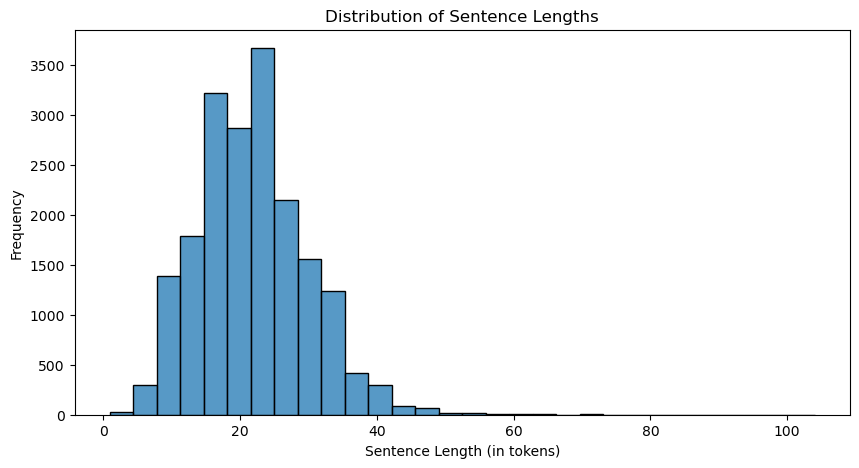

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(sentence_lengths, bins=30, kde=False)
plt.title('Distribution of Sentence Lengths')
plt.xlabel('Sentence Length (in tokens)')
plt.ylabel('Frequency')
plt.show()


In [ ]:
# Most common words
df['Tokens'] = df['Sentence'].apply(lambda x: x.lower().split())


In [ ]:
all_tokens = [token for tokens in df['Tokens'] for token in tokens]
tag_encoder = LabelEncoder()
tag_encoder.fit(all_tags)
tokenizer = Tokenizer(lower=True, oov_token="<OOV>")
tokenizer.fit_on_texts(df['Tokens'])


Most Frequent Words

In [ ]:
token_counts = Counter(all_tokens)
top_words = token_counts.most_common(20)
words, frequencies = zip(*top_words)


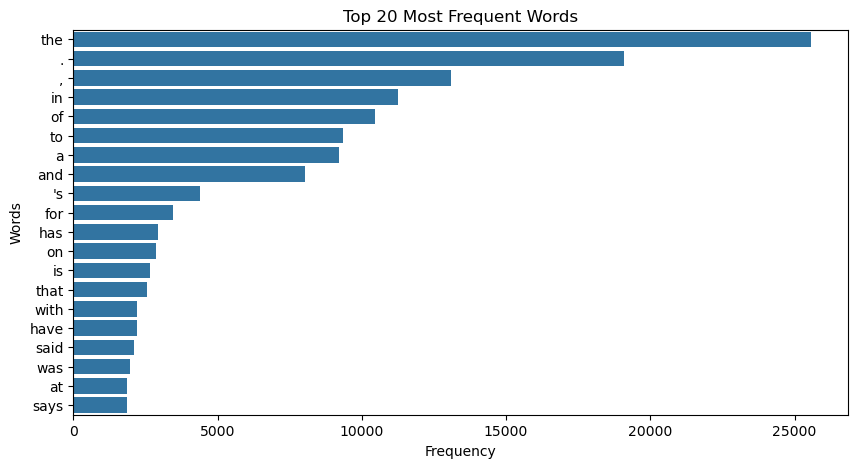

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(x=frequencies, y=words)
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()


In [ ]:
# Most common tags
if not isinstance(df['POS'].iloc[0], list):#checks if list or string
    df['POS'] = df['POS'].apply(ast.literal_eval) # convert string to list
all_tags = [tag for tags in df['POS'] for tag in tags]


In [ ]:
tag_counts = Counter(all_tags)
top_tags = tag_counts.most_common()
tags, frequencies = zip(*top_tags)


Visualize POS Tag Distribution

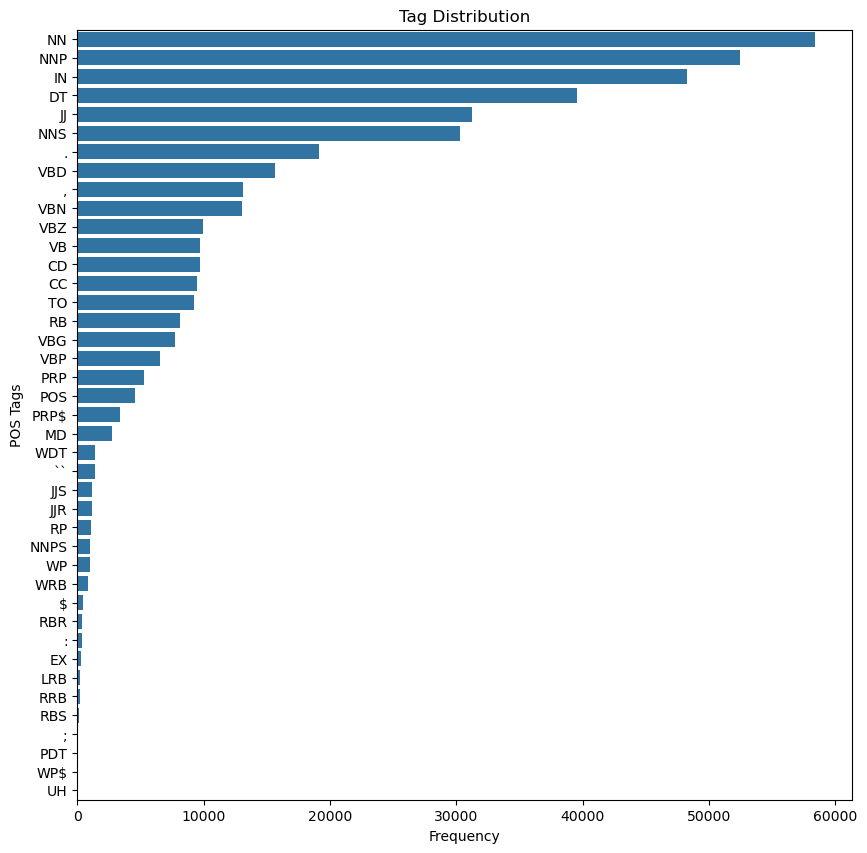

In [ ]:
plt.figure(figsize=(10, 10))
sns.barplot(x=frequencies, y=tags)
plt.title('Tag Distribution')
plt.xlabel('Frequency')
plt.ylabel('POS Tags')
plt.show()


In [ ]:
#checking for mismatch between len(sentence) and len(POS)


In [ ]:
df['pos_count'] = df['POS'].apply(len) # calculate POS tag count
mismatches = df[df['pos_count'] != df['sentence_length']]


In [ ]:
print("Number of mismatches:", len(mismatches))
if len(mismatches) > 0:
    print("Mismatched rows:")
    print(mismatches[['Sentence #', 'Sentence', 'POS', 'pos_count', 'sentence_length']])
else:
    print("No mismatches found.")


Number of mismatches: 3
Mismatched rows:
       Sentence #                                           Sentence  \
8626         8627  In a telephone interview to discuss the issues...   
10197       10198  " And I think they 'll want a one-stop shop in...   
12343       12344  He says they and about 300 party supporters ar...   

                                                     POS  pos_count  \
8626   [IN, DT, NN, NN, TO, VB, DT, NNS, IN, NN, ,, P...         54   
10197  [``, CC, PRP, VBP, PRP, MD, VB, DT, JJ, NN, IN...         38   
12343  [PRP, VBZ, PRP, CC, IN, CD, NN, NNS, VBP, VBG,...         29   

       sentence_length  
8626                52  
10197               37  
12343               28  


In [ ]:
#finding the infrequent tags for stratification


In [ ]:
infrequent_tags = [tag for tag, count in tag_counts.items() if count < 41]


In [ ]:
print("Tags with less than 41 occurrences:", infrequent_tags)


Tags with less than 41 occurrences: ['WP$', 'UH']


#**Data Preprocessing**

In [ ]:
for df in [train_df , test_df ]:
    if not isinstance(df['POS'].iloc[0], list):
        df['POS'] = df['POS'].apply(ast.literal_eval) #It safely evaluates a string containing a Python literal or a container object. Unlike eval(), it only processes basic literals like strings, numbers, lists, tuples, dictionaries, booleans, and None. It raises an error if the input contains anything beyond these, making it significantly safer.
    df['Tokens'] = df['Sentence'].apply(lambda x: x.lower().split())


In [ ]:
    # Prepare label encoder for POS tags
all_tags = [tag for tags in df['POS'] for tag in tags]
tag_encoder = LabelEncoder()
tag_encoder.fit(all_tags)


LabelEncoder()

In [ ]:
tokenizer = Tokenizer(lower=True, oov_token="<OOV>")
tokenizer.fit_on_texts(df['Tokens'])


In [ ]:
#dropping the mismatched rows
for df in [train_df]:
    df = df.drop(mismatches.index)


In [ ]:
#removing infrequent tags for stratification
train_df['stratification_group'] = train_df['POS'].apply(lambda tags: any(tag in infrequent_tags for tag in tags))


In [ ]:
# Convert to sequences
def encode_and_pad(df, max_len):
    X = tokenizer.texts_to_sequences(df['Tokens'])
    y = [[tag_encoder.transform([t])[0] for t in tags] for tags in df['POS']]
    X_pad = pad_sequences(X, maxlen=max_len, padding='post')
    y_pad = pad_sequences(y, maxlen=max_len, padding='post')
    y_cat = to_categorical(y_pad, num_classes=len(tag_encoder.classes_))
    return X_pad, y_cat, y_pad


In [ ]:
#padding done to match the  dimensions of every input text and length


In [ ]:

MAX_LEN = max(train_df['Tokens'].apply(len))
vocab_size = len(tokenizer.word_index) + 1
tag_size = len(tag_encoder.classes_)


In [ ]:

#train and val split
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['stratification_group'])


In [ ]:

X_train, y_train_cat, y_train_flat = encode_and_pad(train_df, MAX_LEN)
X_val, y_val_cat, y_val_flat = encode_and_pad(val_df, MAX_LEN)


In [ ]:
#test_dataset
X_test, y_test_cat, y_test_flat = encode_and_pad(test_df, MAX_LEN)


In [ ]:
print(X_train)


[[  23   17   23 ...    0    0    0]
 [  23 2539    8 ...    0    0    0]
 [  39  120   18 ...    0    0    0]
 ...
 [   2  578  508 ...    0    0    0]
 [   2 3514   18 ...    0    0    0]
 [4103   20    8 ...    0    0    0]]


In [ ]:
#loading embedding for text
def load_embeddings(file_path):
    embeddings_index = {}
    with open(file_path, encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index


In [ ]:
Load and Prepare GloVe Embeddings

In [ ]:
embeddings_index = load_embeddings('/content/glove.6B.300d.txt')
embedding_dim = 300
embedding_matrix = np.zeros((vocab_size, embedding_dim))


In [ ]:
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


In [ ]:
#using tensor slicing for faster
# train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_cat))
# train_dataset = train_dataset.batch(128)
# val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val_cat))
# val_dataset = val_dataset.batch(128)


In [ ]:
# #test
# #creating tf dataset
# test_dataset = tf.data.Dataset.from_tensor_slices(X_test)
# test_dataset = test_dataset.batch(128)


#**Building Models**

Defining  Model

In [ ]:
def build_model(model_type="rnn"):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                    weights=[embedding_matrix], input_length=MAX_LEN, trainable=False))
    if model_type == "rnn":
        model.add(SimpleRNN(32, return_sequences=True))
        model.add(Dropout(0.2))
        model.add(SimpleRNN(32, return_sequences=True))
    elif model_type == "lstm":
        model.add(LSTM(32, return_sequences=True))
        model.add(Dropout(0.2))
        model.add(LSTM(32, return_sequences=True))
    elif model_type == "gru":
        model.add(GRU(32, return_sequences=True))
        model.add(Dropout(0.2))
        model.add(GRU(32, return_sequences=True))
    elif model_type == "bilstm":
        model.add(Bidirectional(LSTM(32, return_sequences=True)))
        model.add(Dropout(0.2))
        model.add(Bidirectional(LSTM(32, return_sequences=True)))
    model.add(TimeDistributed(Dense(tag_size, activation="softmax")))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

Tuning, Early Stop and Learning Rate Controller

In [ ]:

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    models = {
        "RNN": build_model("rnn"),
        "LSTM": build_model("lstm"),
        "GRU": build_model("gru"),
        "BiLSTM": build_model("bilstm")
    }
# learning rate adjustment
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Metric to monitor
    factor=0.5,          # Factor by which the learning rate will be reduced
    patience=2,          # Number of epochs with no improvement before reducing the learning rate
    min_lr=1e-6          # Minimum learning rate
)
# early stopping
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Metric to monitor
    patience=3,          # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore the best weights after stopping
)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


C:\Users\Al Mumit\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


#**Training**

In [ ]:
"""TRAINING LOOP"""
callbacks = [early_stopping, reduce_lr]
history = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    hist = model.fit(X_train, y_train_cat, batch_size=256, epochs=15, validation_split=0.1, callbacks=callbacks, verbose=1)
    history[name] = hist



Training RNN...

Epoch 1/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - accuracy: 0.5085 - loss: 2.5795 - val_accuracy: 0.8344 - val_loss: 0.7913 - learning_rate: 0.0010
Epoch 2/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.8345 - loss: 0.7381 - val_accuracy: 0.8598 - val_loss: 0.5903 - learning_rate: 0.0010
Epoch 3/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.8587 - loss: 0.5807 - val_accuracy: 0.8811 - val_loss: 0.4907 - learning_rate: 0.0010
Epoch 4/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.8806 - loss: 0.4895 - val_accuracy: 0.8982 - val_loss: 0.4141 - learning_rate: 0.0010
Epoch 5/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.8956 - loss: 0.4210 - val_accuracy: 0.9075 - val_loss: 0.3596 - learning_rate: 0.0010
Epoch 6/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.9057 - loss: 0.3696 - val_accuracy: 0.9179 - val_loss: 0.3199 - learning_rate: 0.0010
Epoch 7/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.9139 - los

#**Validation Set Evaluation and Charts**

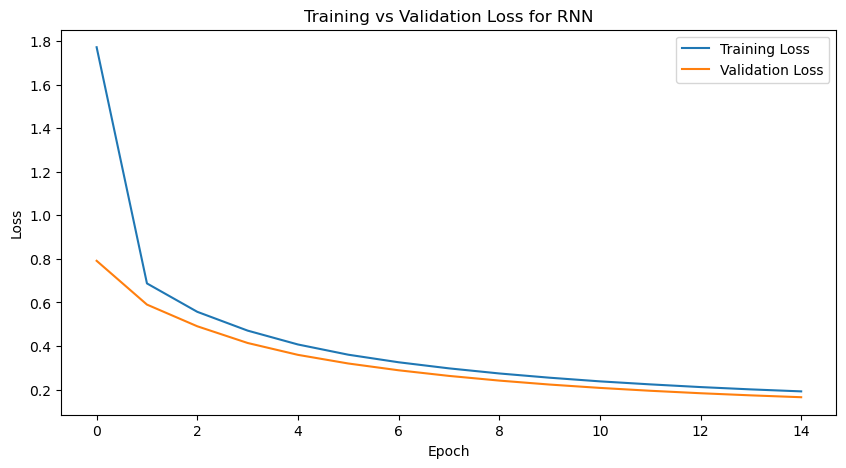

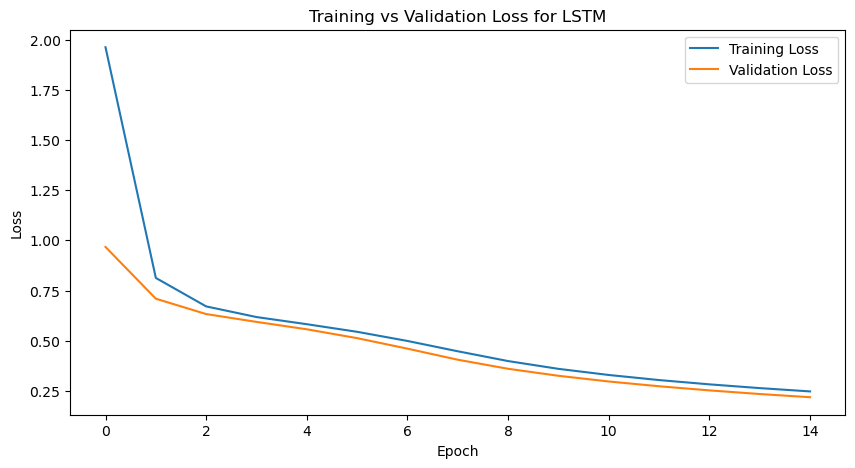

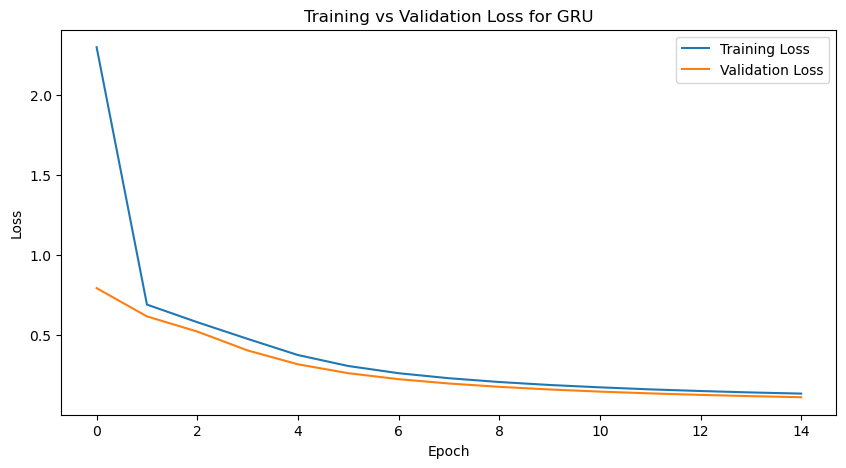

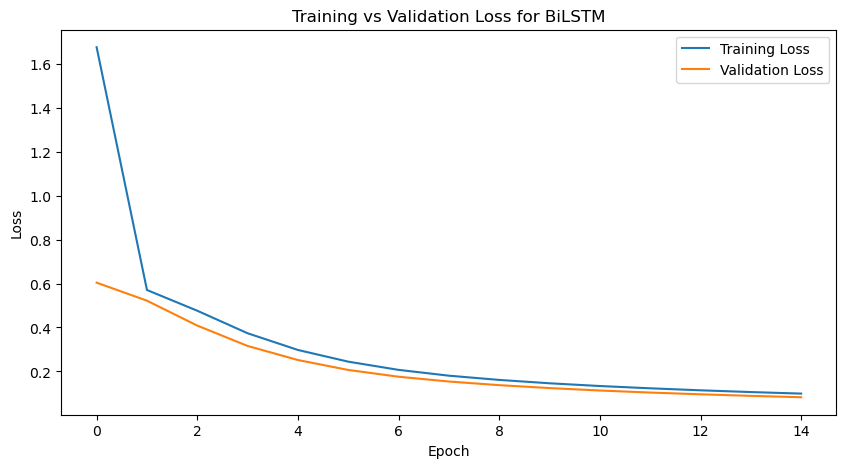

In [ ]:
for name, hist in history.items():
    plt.figure(figsize=(10, 5))
    plt.plot(hist.history['loss'], label='Training Loss')
    plt.plot(hist.history['val_loss'], label='Validation Loss')
    plt.title(f'Training vs Validation Loss for {name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


Evaluating Models on Validation Set

In [ ]:
def evaluate_model(name, model):
    y_pred = model.predict(X_val)
    y_pred_flat = np.argmax(y_pred, axis=-1).flatten()
    y_true_flat = y_val_flat.flatten()
    mask = y_true_flat > 0  # mask out padding
    y_pred_masked = y_pred_flat[mask]
    y_true_masked = y_true_flat[mask]
    print(f"\n=== {name} Evaluation ===")
    print("Accuracy:", accuracy_score(y_true_masked, y_pred_masked))
    print("F1 Score (macro):", f1_score(y_true_masked, y_pred_masked, average='macro'))
    print("\nClassification Report:\n", classification_report(y_true_masked, y_pred_masked, target_names=tag_encoder.classes_))
    # Confusion matrix
    cm = confusion_matrix(y_true_masked, y_pred_masked)
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, xticklabels=tag_encoder.classes_, yticklabels=tag_encoder.classes_, cmap="Blues", annot=False, fmt="d")
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


Visualizing Model Performance

120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step

=== RNN Evaluation ===
Accuracy: 0.7824794062278925
F1 Score (macro): 0.40231145869468055

Classification Report:
               precision    recall  f1-score   support

           $       0.00      0.00      0.00         0
           ,       0.97      1.00      0.98      2592
           .       0.98      1.00      0.99      3828
           :       0.00      0.00      0.00        67
           ;       0.00      0.00      0.00        19
          CC       0.93      0.96      0.94      1882
          CD       0.73      0.74      0.74      1978
          DT       0.96      0.97      0.97      7883
          EX       0.00      0.00      0.00        51
          IN       0.88      0.96      0.92      9487
          JJ       0.63      0.55      0.59      6180
         JJR       0.00      0.00      0.00       226
         JJS       0.00      0.00      0.00       226
         LRB       0.00      0.00      0.00        54
          MD       0.93      0.

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklea

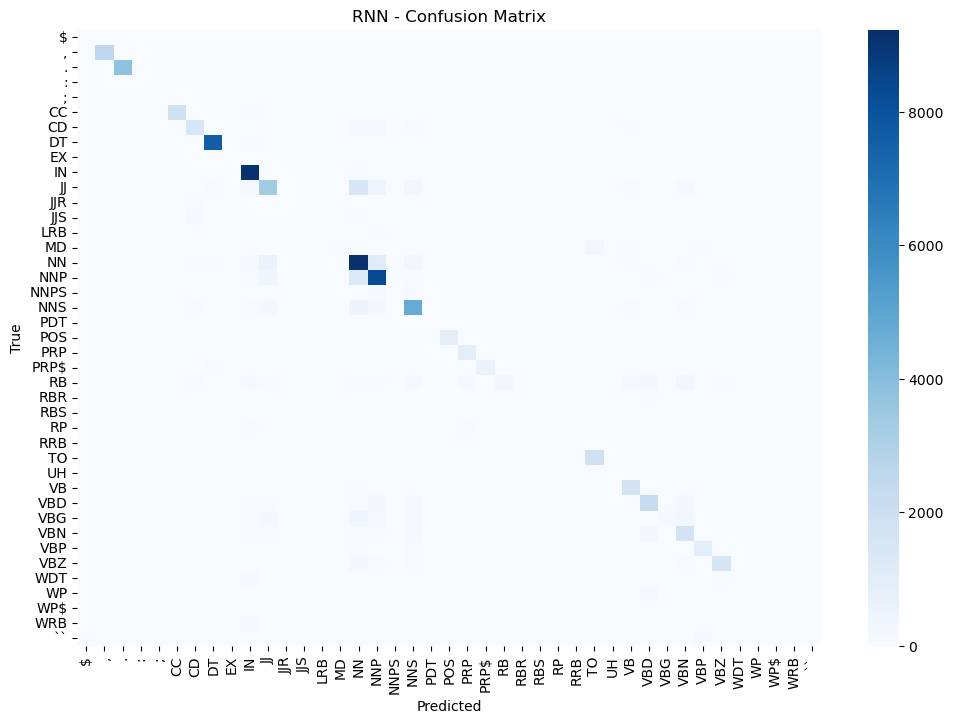

120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step

=== LSTM Evaluation ===
Accuracy: 0.7234259403589971
F1 Score (macro): 0.30361055028139927

Classification Report:
               precision    recall  f1-score   support

           $       0.00      0.00      0.00         0
           ,       0.88      1.00      0.94      2592
           .       1.00      1.00      1.00      3828
           :       0.00      0.00      0.00        67
           ;       0.00      0.00      0.00        19
          CC       0.62      0.95      0.75      1882
          CD       0.75      0.76      0.76      1978
          DT       0.86      0.97      0.91      7883
          EX       0.00      0.00      0.00        51
          IN       0.86      0.97      0.91      9487
          JJ       0.64      0.45      0.53      6180
         JJR       0.00      0.00      0.00       226
         JJS       0.00      0.00      0.00       226
         LRB       0.00      0.00      0.00        54
          MD       0.00      0

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklea

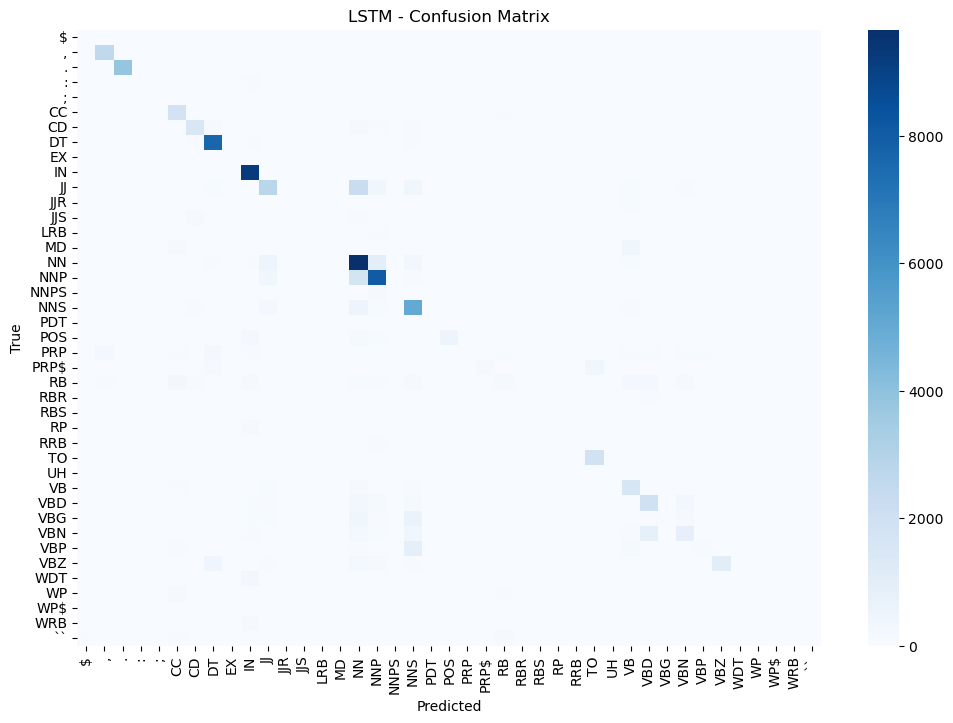

120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step

=== GRU Evaluation ===
Accuracy: 0.8535593951965851
F1 Score (macro): 0.5302349272509285

Classification Report:
               precision    recall  f1-score   support

           $       0.00      0.00      0.00         0
           ,       0.99      1.00      0.99      2592
           .       1.00      1.00      1.00      3828
           :       0.00      0.00      0.00        67
           ;       0.00      0.00      0.00        19
          CC       0.96      0.99      0.98      1882
          CD       0.87      0.86      0.87      1978
          DT       0.99      0.98      0.98      7883
          EX       0.00      0.00      0.00        51
          IN       0.92      0.98      0.95      9487
          JJ       0.72      0.74      0.73      6180
         JJR       0.93      0.30      0.45       226
         JJS       0.00      0.00      0.00       226
         LRB       0.00      0.00      0.00        54
          MD       0.96      0.9

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklea

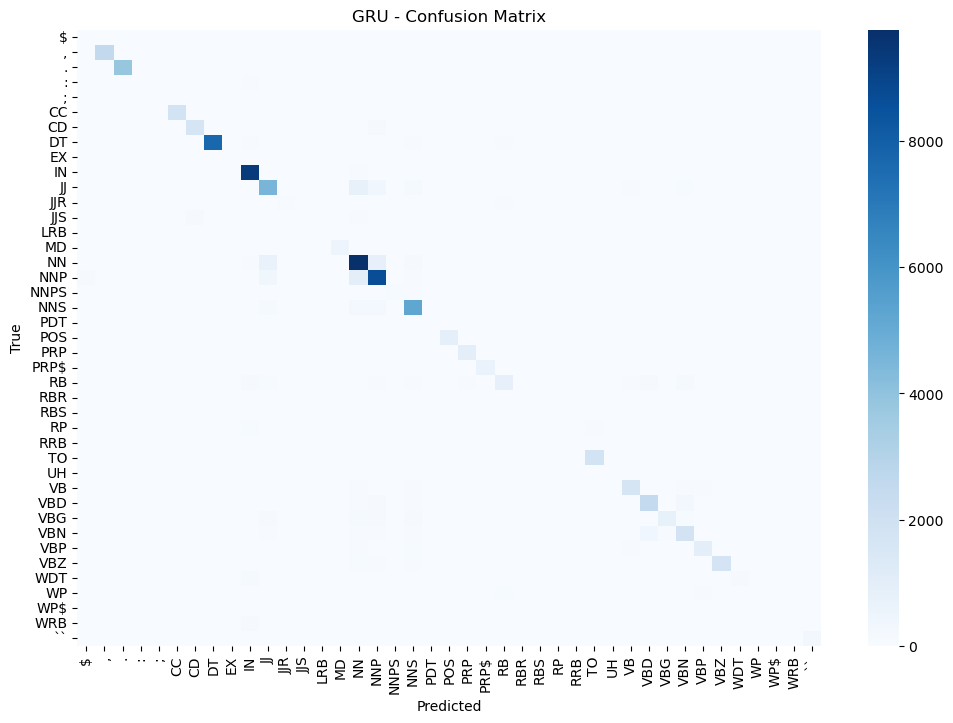

120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step

=== BiLSTM Evaluation ===
Accuracy: 0.8916054149330328
F1 Score (macro): 0.5651693446097761

Classification Report:
               precision    recall  f1-score   support

           $       0.00      0.00      0.00         0
           ,       0.96      1.00      0.98      2592
           .       1.00      1.00      1.00      3828
           :       0.00      0.00      0.00        67
           ;       0.00      0.00      0.00        19
          CC       0.99      0.98      0.99      1882
          CD       0.92      0.89      0.90      1978
          DT       0.99      0.98      0.99      7883
          EX       0.00      0.00      0.00        51
          IN       0.94      0.99      0.96      9487
          JJ       0.78      0.85      0.82      6180
         JJR       0.88      0.64      0.74       226
         JJS       1.00      0.25      0.40       226
         LRB       0.00      0.00      0.00        54
          MD       0.91      

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklea

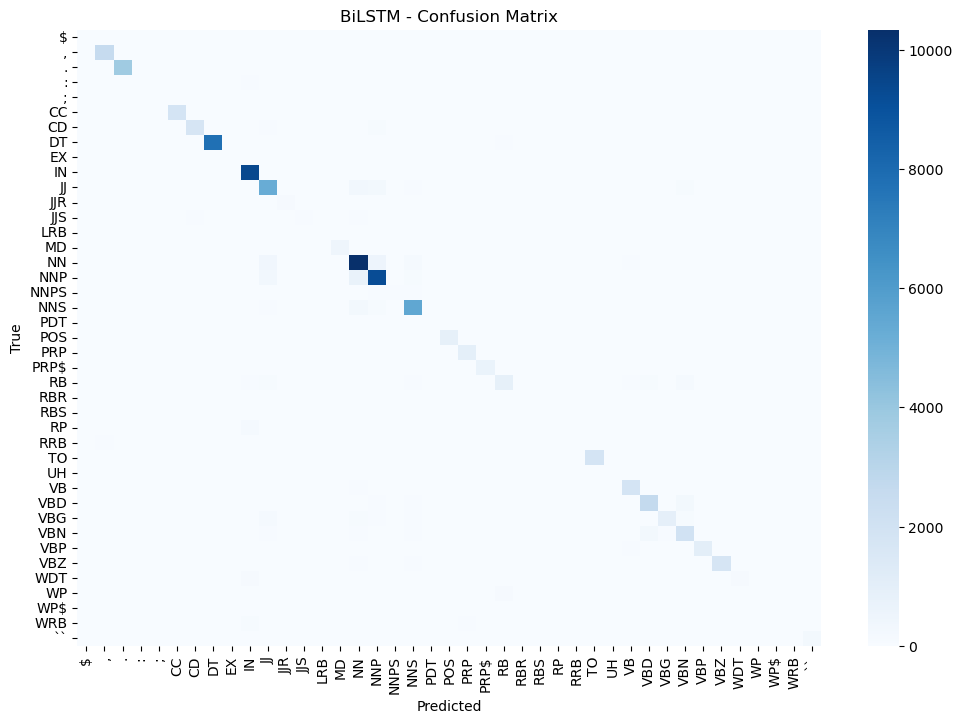

In [ ]:
# Evaluate each model
for name, model in models.items():
    evaluate_model(name, model)


#**Model Test Scores**

Evaluating Models on Test Set

In [ ]:
def evaluate_test_model(name, model, X_test, y_test_flat, num_predictions_to_show=5):  # Added X_test and y_test_flat as arguments
        y_pred = model.predict(X_test)
        # print(f"\n=== {name} Predictions (Showing {num_predictions_to_show} out of {len(test_df)}) ===")
        # Convert predictions to tag labels
        # predicted_tags = [[tag_encoder.inverse_transform([np.argmax(tag)])[0] for tag in seq] for seq in y_pred]
        # for i, sentence in enumerate(test_df['Sentence']):
        #     if i >= num_predictions_to_show:
        #         break
        #     print(f"Sentence: {sentence}")
        #     print(f"Predicted POS tags: {predicted_tags[i][:len(test_df['Tokens'][i])]}")  # Print tags only for the sentence length
        #     print("-" * 20)
        y_pred_flat = np.argmax(y_pred, axis=-1).flatten()
        y_true_flat = y_test_flat.flatten()
        mask = y_true_flat > 0  # mask out padding
        y_pred_masked = y_pred_flat[mask]
        y_true_masked = y_true_flat[mask]
        # Metrics
        acc = accuracy_score(y_true_masked, y_pred_masked)
        f1_macro = f1_score(y_true_masked, y_pred_masked, average='macro')
        f1_weighted = f1_score(y_true_masked, y_pred_masked, average='weighted')
        report = classification_report(y_true_masked, y_pred_masked, target_names=tag_encoder.classes_)
        # Append scores to DataFrame
        scores_df.loc[len(scores_df)] = {
            'Model': name,
            'Accuracy': acc,
            'F1 Score (macro)': f1_macro,
            'F1 Score (weighted)': f1_weighted,
            'Classification Report': report
        }
        # Print metrics
        print(f"\n=== {name} Evaluation ===")
        print("Accuracy:", acc)
        print("F1 Score (macro):", f1_macro)
        print("F1 Score (weighted):", f1_weighted)
        print("\nClassification Report:\n", report)
        # Confusion matrix
        cm = confusion_matrix(y_true_masked, y_pred_masked)
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, xticklabels=tag_encoder.classes_, yticklabels=tag_encoder.classes_, cmap="Blues", annot=False, fmt="d")
        plt.title(f"{name} - Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklea


=== RNN Evaluation ===
Accuracy: 0.7874232720776876
F1 Score (macro): 0.40204115461812656
F1 Score (weighted): 0.7671112606134538

Classification Report:
               precision    recall  f1-score   support

           $       0.00      0.00      0.00         0
           ,       0.96      1.00      0.98      3314
           .       0.97      1.00      0.98      4789
           :       0.00      0.00      0.00        73
           ;       0.00      0.00      0.00        22
          CC       0.93      0.96      0.95      2474
          CD       0.72      0.76      0.74      2522
          DT       0.95      0.97      0.96      9797
          EX       0.00      0.00      0.00        75
          IN       0.87      0.96      0.91     12190
          JJ       0.64      0.57      0.60      7807
         JJR       0.00      0.00      0.00       291
         JJS       0.00      0.00      0.00       309
         LRB       0.00      0.00      0.00        67
          MD       0.92      0.13

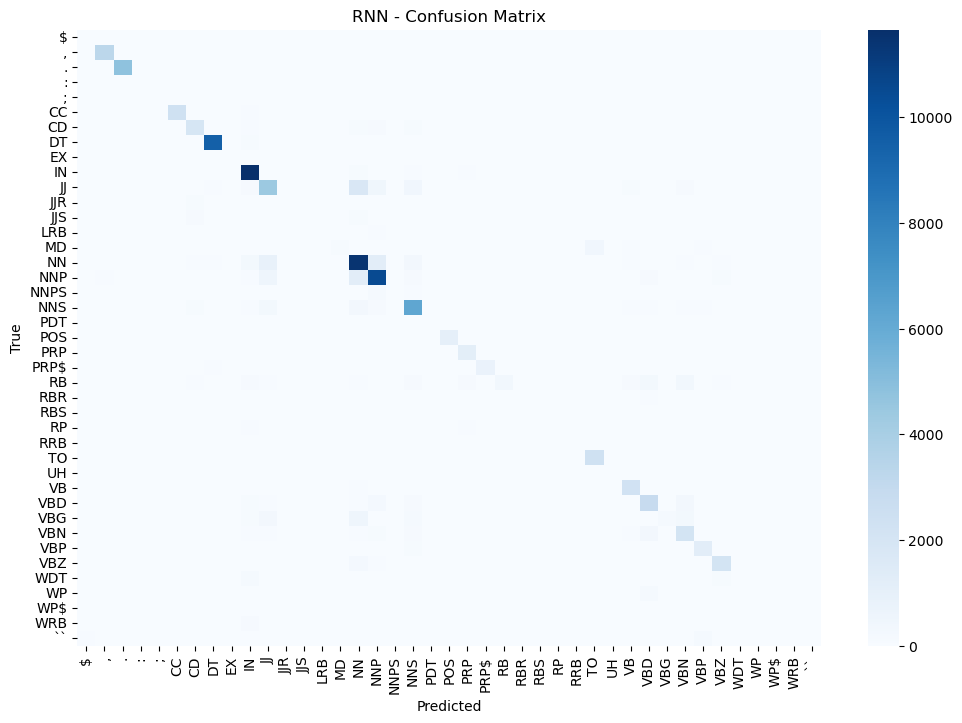

150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklea


=== LSTM Evaluation ===
Accuracy: 0.735333802094221
F1 Score (macro): 0.30684254950035095
F1 Score (weighted): 0.697220530961848

Classification Report:
               precision    recall  f1-score   support

           $       0.00      0.00      0.00         0
           ,       0.88      1.00      0.94      3314
           .       0.99      1.00      1.00      4789
           :       0.00      0.00      0.00        73
           ;       0.00      0.00      0.00        22
          CC       0.65      0.95      0.77      2474
          CD       0.75      0.80      0.77      2522
          DT       0.85      0.97      0.90      9797
          EX       0.00      0.00      0.00        75
          IN       0.85      0.97      0.91     12190
          JJ       0.67      0.49      0.57      7807
         JJR       0.00      0.00      0.00       291
         JJS       0.00      0.00      0.00       309
         LRB       0.00      0.00      0.00        67
          MD       0.00      0.00 

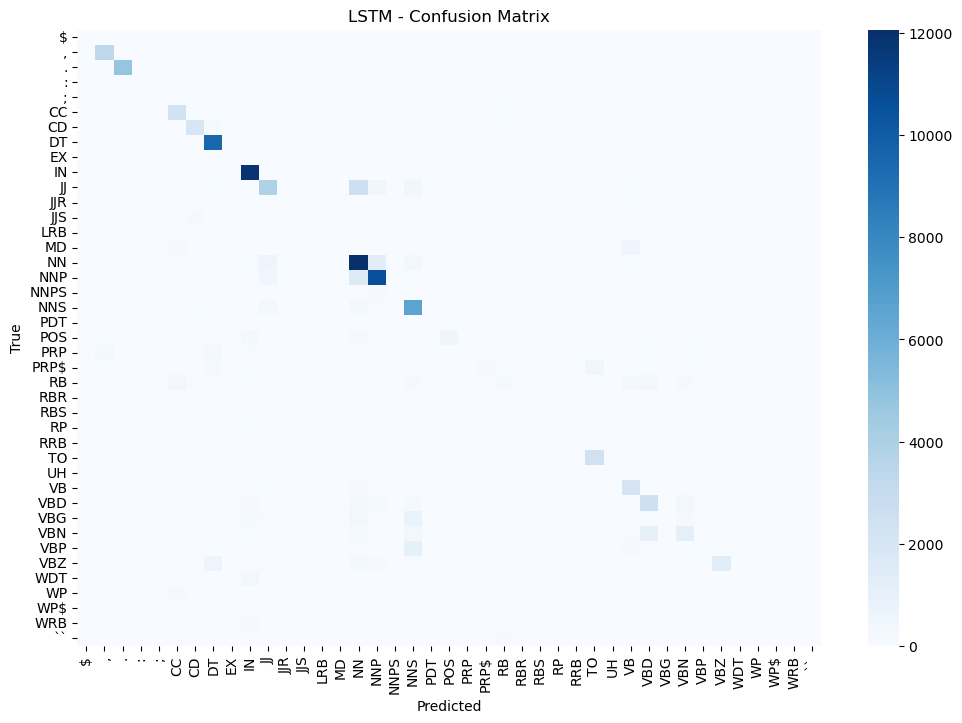

150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklea


=== GRU Evaluation ===
Accuracy: 0.8671728017331484
F1 Score (macro): 0.5339674020941393
F1 Score (weighted): 0.8595572141481046

Classification Report:
               precision    recall  f1-score   support

           $       0.00      0.00      0.00         0
           ,       0.97      1.00      0.99      3314
           .       1.00      1.00      1.00      4789
           :       0.00      0.00      0.00        73
           ;       0.00      0.00      0.00        22
          CC       0.95      0.99      0.97      2474
          CD       0.86      0.91      0.88      2522
          DT       0.99      0.98      0.98      9797
          EX       0.00      0.00      0.00        75
          IN       0.92      0.98      0.95     12190
          JJ       0.73      0.76      0.74      7807
         JJR       0.87      0.33      0.48       291
         JJS       0.00      0.00      0.00       309
         LRB       0.00      0.00      0.00        67
          MD       0.97      0.92 

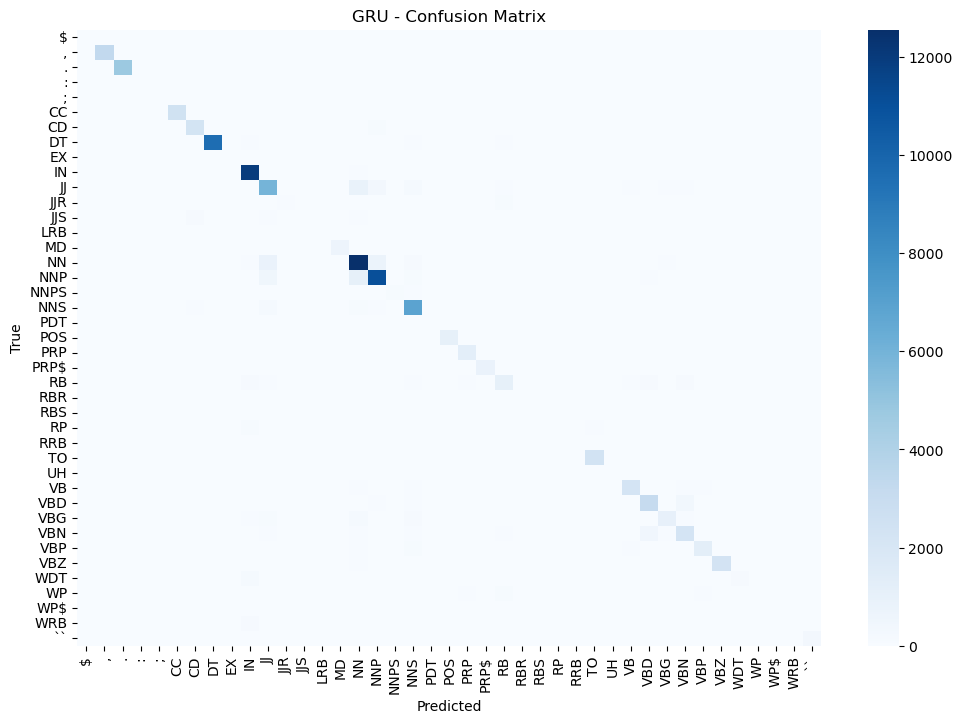

150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklea


=== BiLSTM Evaluation ===
Accuracy: 0.9034035841204082
F1 Score (macro): 0.5669997687100454
F1 Score (weighted): 0.8969346181366983

Classification Report:
               precision    recall  f1-score   support

           $       0.00      0.00      0.00         0
           ,       0.96      1.00      0.98      3314
           .       1.00      1.00      1.00      4789
           :       0.00      0.00      0.00        73
           ;       0.00      0.00      0.00        22
          CC       0.98      0.98      0.98      2474
          CD       0.91      0.94      0.93      2522
          DT       0.99      0.99      0.99      9797
          EX       0.00      0.00      0.00        75
          IN       0.94      0.99      0.96     12190
          JJ       0.82      0.86      0.84      7807
         JJR       0.87      0.70      0.77       291
         JJS       0.98      0.21      0.34       309
         LRB       0.00      0.00      0.00        67
          MD       0.91      0.

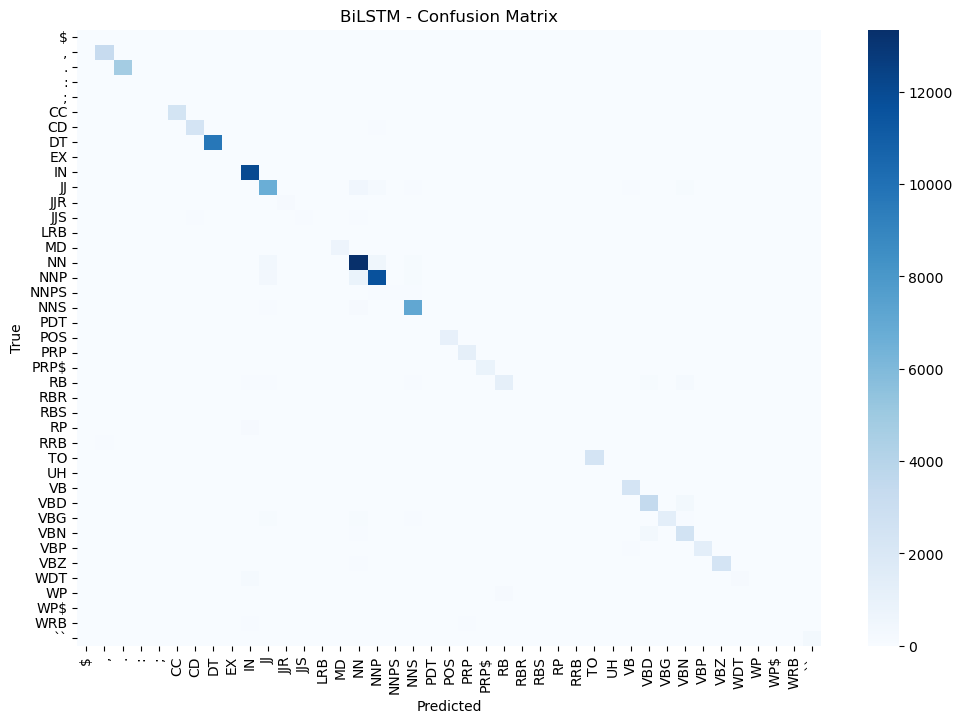

In [ ]:

# Create a Pandas DataFrame from the scores dictionary
scores_df = pd.DataFrame(columns=[
    'Model',
    'Accuracy',
    'F1 Score (macro)',
    'F1 Score (weighted)',
    'Classification Report'
])
# Evaluate each model
for name, model in models.items():
    evaluate_test_model(name, model, X_test, y_test_flat)


#**Test Comparison Visualization**

In [ ]:
# Drop 'Classification Report' (not numerical) for plotting
plot_df = scores_df.drop(columns=['Classification Report'])


In [ ]:
# Melt into long format for Seaborn
scores_df_melted = plot_df.melt(id_vars='Model', var_name='Metric', value_name='Score')


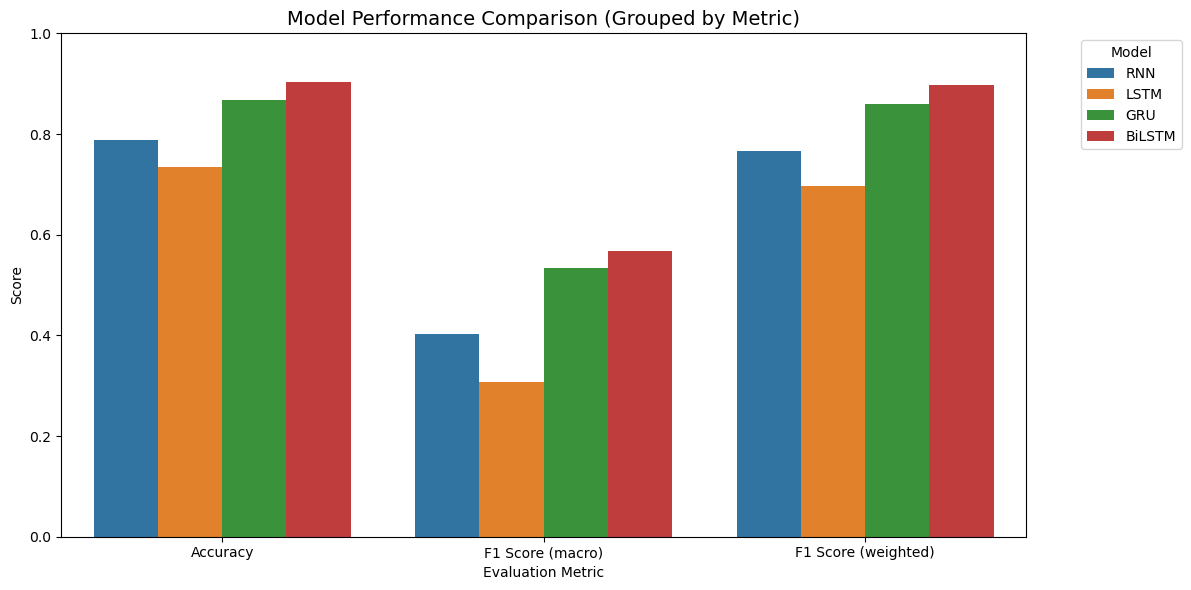

In [ ]:
#grouped bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x='Metric', y='Score', hue='Model', data=scores_df_melted)
plt.title('Model Performance Comparison (Grouped by Metric)', fontsize=14)
plt.xlabel('Evaluation Metric')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


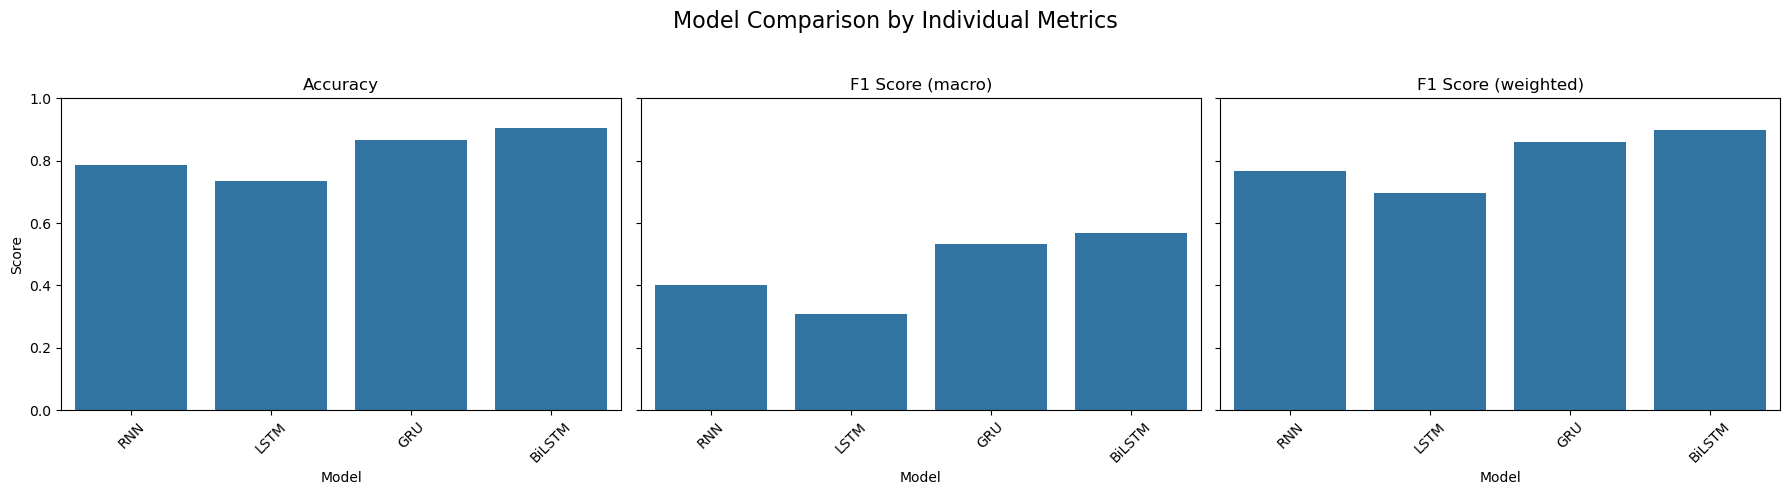

In [ ]:
#per metric chart
metrics = scores_df_melted['Metric'].unique()
fig, axes = plt.subplots(1, len(metrics), figsize=(6 * len(metrics), 5), sharey=True)

for i, metric in enumerate(metrics):
    sns.barplot(x='Model', y='Score', data=scores_df_melted[scores_df_melted['Metric'] == metric], ax=axes[i])
    axes[i].set_title(metric)
    axes[i].set_ylim(0, 1)
    axes[i].tick_params(axis='x', rotation=45)
plt.suptitle('Model Comparison by Individual Metrics', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

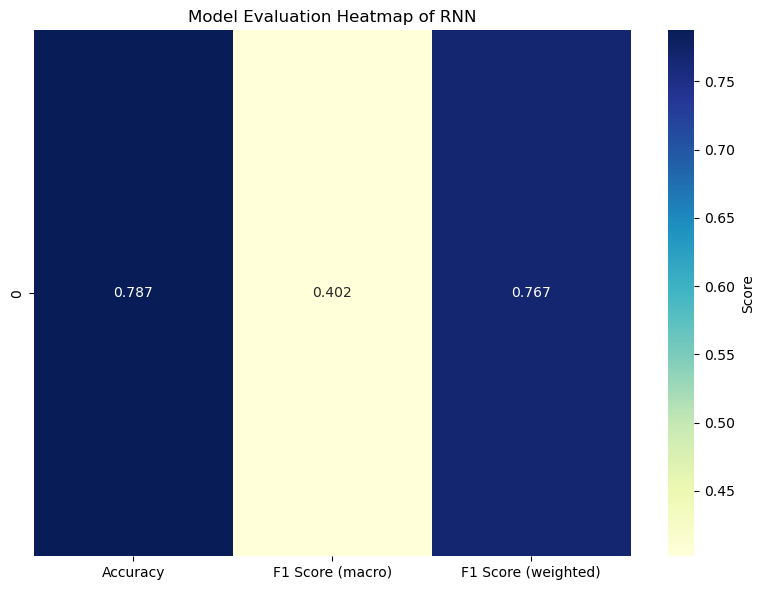

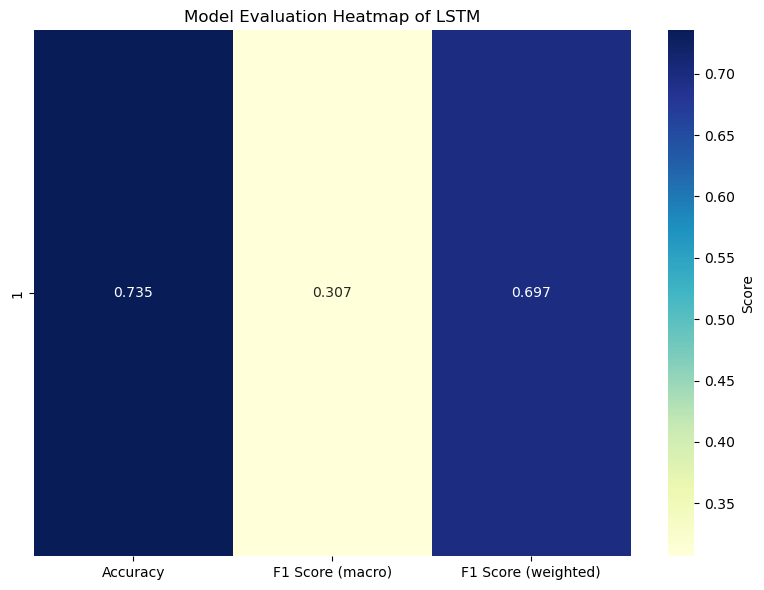

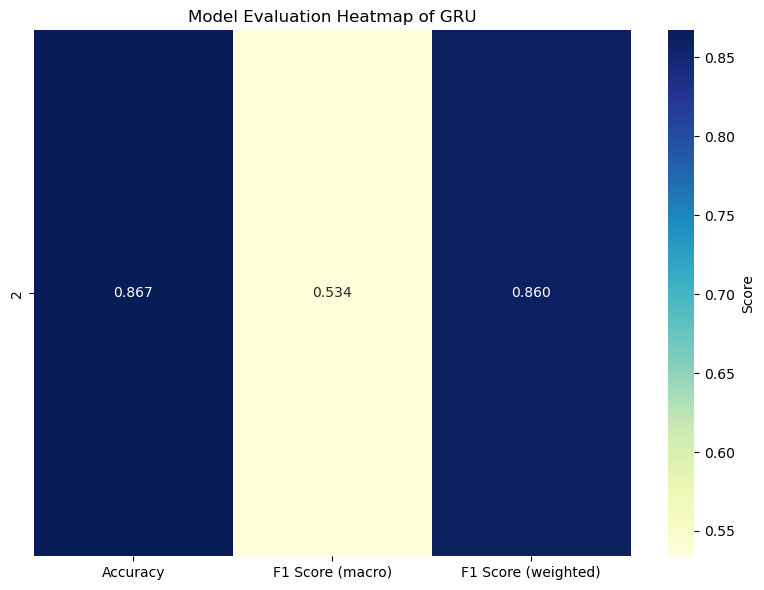

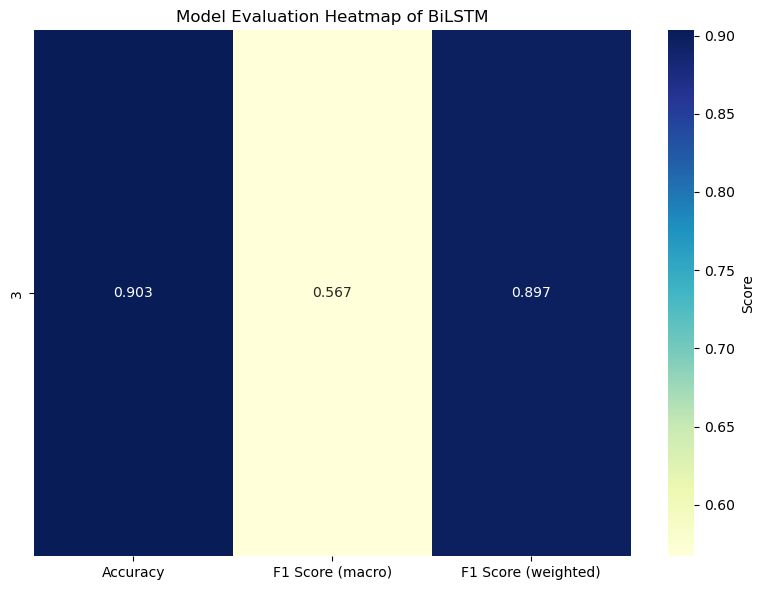

In [ ]:
def heatmap_plot(model_name):
    heatmap_data = plot_df[plot_df['Model'] == model_name].drop(columns=['Model'])
    plt.figure(figsize=(8, 6))
    sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt=".3f", cbar_kws={'label': 'Score'})
    plt.title(f'Model Evaluation Heatmap of {model_name}')
    plt.tight_layout()
    plt.show()
for name, model in models.items():
    heatmap_plot(name)